In [ ]:
import sys
import datetime
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

sys.path.append('..')

from definitions import INPUT_DATA_DIR, PARSED_DATA_DIR, SUB_DIR, FULL_DATA_DIR, INPUT_DATA_DIR, AUTHORS_DIR

%reload_ext autoreload
%autoreload 2

In [ ]:
version = {
    'lightgbm': lgb.__version__,
    'pandas': pd.__version__,
    'numpy': np.__version__,
    'scikit-learn': sk.__version__ 
}
print(version)

# 1. Загрузка данных

In [ ]:
from src.transformers.base import Compose
from src.transformers.preprocess import (
    LoaderMergePreprocess, 
    CategoryFromTextPreprocess, 
    AuthorsPreprocess,
    TagsPreprocess,
    FeaturePreprocess,
    SaverPreprocess,
    NatashaTransformer
)

In [ ]:
Preprocessor = Compose(
    transforms=[
        LoaderMergePreprocess(name='loading'),
        CategoryFromTextPreprocess(name='category from text'),
        AuthorsPreprocess(name='authors preprocess'),
        TagsPreprocess(name='tags preprocess'),
        FeaturePreprocess(name='feature selector'),
        NatashaTransformer(name='natasha name entity'),
        SaverPreprocess(name='saving files')
    ]
)

Данный код запускет `preprocessing` данных

In [ ]:
train = Preprocessor(data=pd.DataFrame(), mode='train')
test = Preprocessor(data=pd.DataFrame(), mode='test')

Либо можно их сразу загрузить

In [ ]:
train = pd.read_json(FULL_DATA_DIR / 'full_train.json')
test = pd.read_json(FULL_DATA_DIR / 'full_test.json')
authors = pd.read_json(AUTHORS_DIR / 'authors.json').T

## 2. Предсказание для существующих

In [ ]:
from src.prediction.utils import predict_for_exist
from src.constants import FeaturesConstants

In [ ]:
exist_prediction = predict_for_exist(train, test)
train_and_tests_ctr_ = list(set(train['page_id']) & set(test['page_id']))

In [497]:
train_data = (
    train[~(train['page_id'].isin(train_and_tests_ctr_))]
    .drop_duplicates(FeaturesConstants.target + ['document_id', 'page_id', 'ctr'])
)
train_data = train_data[train_data['full_reads_percent'] <= 100]
# train_data = train_data[pd.to_datetime(train_data['publish_date']).dt.year >= 2022]
train_data = train_data[train_data['views'] <= 1000000].copy()

test_data = test[~(test['page_id'].isin(train_and_tests_ctr_))].copy()

In [498]:
y_data = train_data[FeaturesConstants.target].copy()

In [499]:
train_data.shape, test_data.shape

((6918, 30), (2967, 27))

## 3. Feature Generation

## 3.1 Identifier

- `page_id`: `624ac09c9a7947db3d80c98e`

## 3.2 Date

- `publish_date`: `2022-04-04 10:29:44` + `timedelta(hours=3)`

## 3.3 Title

- `title` - title новости от организаторов, (**текст**)
- `title_parsed` - спарсенный title новости, (**текст**)
- `optional[title_parsed_from_yandex]` - заголовок статьи в `yandex`, (**текст**)
- `title_preprocessed` - удалены `category`

## 3.4 Category

- `category` - категория новости, **hash**
- `category_parsed` - спарсенная категория новости, **текст**
- `category_from_title` - категория, выделенная из текста, **Optional[текст]**

## 3.5 Ctr

- `ctr` - показатель кликабельности, **Optional[float64]**

## 3.6 Tags

- `tags` - таги, закодированные от организаторов, **Optional[hash]**
- `tags_parsed` - спарсенные тэги, **Optional[текст]**

## 3.7 Auhtors

- `authors` - авторы новости от организаторов, **Optional[hash]**
- `authors_parsed` - авторы новости **Optional[текст]**

## 3.8 Text

- `news_text_parsed` - текст новости, полный, **текст** 
- `news_text_overview_parsed` - некоторая выжимка новости, **текст**
- `news_amount_of_paragraphs_parsed` - количество параграфов в тексте, **int64**
- `news_amount_of_inline_items_parsed` - количество ссылок на другие новости в тексте новости, **int64**
- `news_inline_titles_parsed` - заголовки на другие статьи в тексте новости, **Optional[текст]**
- `news_has_image_parsed` - есть ли в новости картинка, **int64**
- `news_image_title_parsed` - подпись к изображению, если есть, **Optional[текст]**

## 3.9. Features Selector Transformer

In [500]:
from src.transformers.feature_generation import (
    DatetimeTransformer,
    TitleTransformer,
    CategoryTransformer,
    CTRTransformer,
    TagsTransformer,
    AuthorsTransformer,
    TextTransformer,
    NatashaTextTransformer,
    FeatureSelector,
    TfidfVectorTransformer,
    CountTfIdfVectorizer,
    MultiLabelTransformer
)


In [501]:
# train_data['type'] = 'train'
# test_data['type'] = 'test'

In [502]:
# values = pd.concat(
#     [
#         train_data.drop(FeaturesConstants.target, axis=1),
#         test_data
#     ]
# )
# values['publish_date'] = pd.to_datetime(values['publish_date'])
# values['date'] = values['publish_date'].dt.date
# values = values.sort_values(by='publish_date')

# 4. Model Fitting

In [503]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import optuna

from sklearn.model_selection import RepeatedKFold
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)

import warnings
warnings.filterwarnings("ignore")

In [504]:
m = MultiLabelTransformer()
m.fit(train_data)
train_author = m.transform(train_data)
test_author = m.transform(test_data)
# train_features = pd.concat([train_features, train_author], axis=1)
# test_features = pd.concat([test_features, test_author], axis=1)

In [505]:
# from sentence_transformers import SentenceTransformer

# model = SentenceTransformer(FeaturesConstants.MODEL_NAME)

In [506]:
# train_embeddings = model.encode(train_data['title_preprocessed'].values)

In [507]:
# tets_embeddings = model.encode(test_data['title_preprocessed'].values)

In [508]:
# train_embeddings.shape, tets_embeddings.shape

# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=48).fit(np.concatenate((train_embeddings, tets_embeddings)))
# train_data['cluster'] = kmeans.predict(train_embeddings)
# test_data['cluster'] = kmeans.predict(tets_embeddings)

In [509]:
def plotImp(
    model,
    X, 
    num=10, 
    fig_size = (40, 20)
):
    feature_imp = pd.DataFrame(
        {'Value': model.feature_importances_,
         'Feature': X.columns}
    )
    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    sns.barplot(
        x="Value", 
        y="Feature", 
        data=feature_imp.sort_values(by="Value", ascending=False)[0:num],
        ax=ax
    )
    plt.show()
    


In [510]:
kfold = KFold(n_splits=3, shuffle=True, random_state=239)

[]
[]
[]
views:  0.7204635722197791


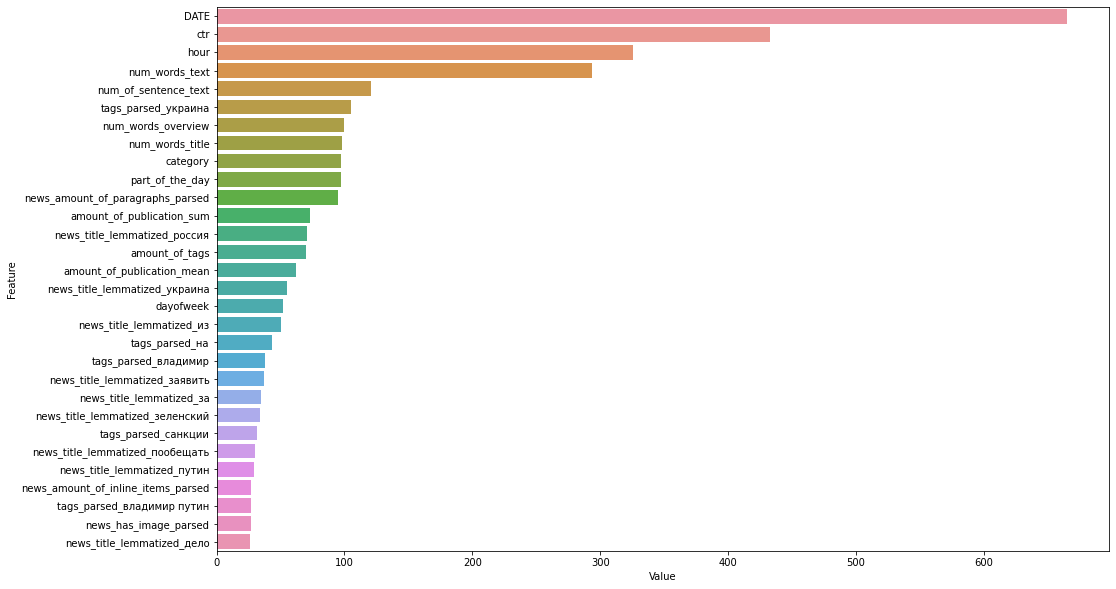

[]
[]
[]
depth:  0.8427408334830392


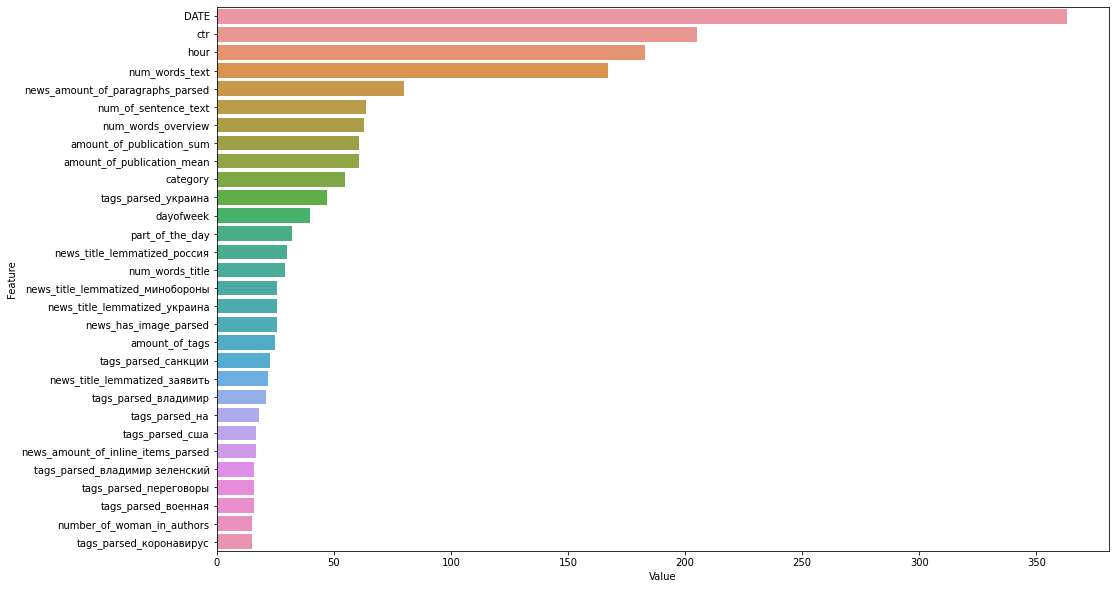

[]
[]
[]
full_reads_percent:  0.541878251999671


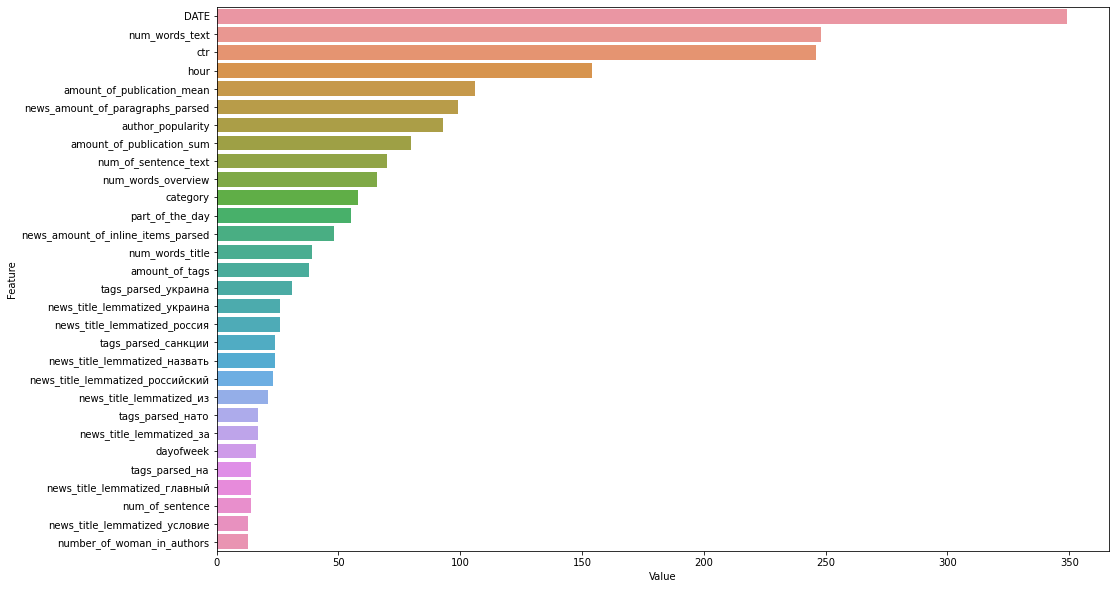

Final score: 0.7035711545327247, median: 0.7032311409188912


In [567]:
result_dict = {
    'views': {'r2': [], 'trees': [], 'prediction': []},
    'full_reads_percent': {'r2': [], 'trees': [], 'prediction': []},
    'depth': {'r2': [], 'trees': [], 'prediction': []}
}
for target_variable in FeaturesConstants.target:
#     if target_variable in ['views', 'depth']:
#         continue
    FeatureGenerator = Compose(
        transforms=[
            DatetimeTransformer(full='use' if target_variable == 'full_reads_percent' else None),
            TitleTransformer(),
            CTRTransformer(eps=0.1 if target_variable == 'views' else 0.5),
            TagsTransformer(),
            AuthorsTransformer(),
            TextTransformer(use_text_transformer=target_variable if target_variable == 'full_reads_percent' else None),
            NatashaTextTransformer(),
            CategoryTransformer(),
            FeatureSelector()
        ]
    )
    train_features = FeatureGenerator(data=train_data, mode='train')
    test_features = FeatureGenerator(data=test_data, mode='test')
    
    tfidf = TfidfVectorTransformer(
        col='news_title_lemmatized',
        tfidf_vectorizer=TfidfVectorizer(
            ngram_range=(1, 4) if target_variable != 'full_reads_percent' else (1, 4),
            max_features=256 if target_variable != 'full_reads_percent' else 2048,
            min_df=3 if target_variable != 'full_reads_percent' else 1
        )
    )
    tfidf.fit(train_data)
    train_dd = tfidf.transform(train_data)
    test_dd = tfidf.transform(test_data)
    train_features = pd.concat([train_features, train_dd], axis=1)
    test_features = pd.concat([test_features, test_dd], axis=1)
    
        
    tfidf = TfidfVectorTransformer(
        col='tags_parsed',
        tfidf_vectorizer=TfidfVectorizer(
            ngram_range=(1, 4) if target_variable != 'full_reads_percent' else (1, 4),
            max_features=256 if target_variable != 'full_reads_percent' else 2048,
            min_df=5 if target_variable != 'full_reads_percent' else 1
        )
    )
    tfidf.fit(train_data)
    train_dd = tfidf.transform(train_data)
    test_dd = tfidf.transform(test_data)
    train_features = pd.concat([train_features, train_dd], axis=1)
    test_features = pd.concat([test_features, test_dd], axis=1)
    
    
    tfidf = TfidfVectorTransformer(
        col='authors_parsed',
        tfidf_vectorizer=TfidfVectorizer(
            ngram_range=(1, 4),
            max_features=128 if target_variable != 'views' else 64
        )
    )
    tfidf.fit(train_data)
    train_dd = tfidf.transform(train_data)
    test_dd = tfidf.transform(test_data)
    train_features = pd.concat([train_features, train_dd], axis=1)
    test_features = pd.concat([test_features, test_dd], axis=1)
    
# # #     train_features = pd.concat((train_features, pd.DataFrame(train_embeddings, index=train_features.index)), axis=1)
# # #     test_features = pd.concat((test_features, pd.DataFrame(tets_embeddings, index=test_features.index)), axis=1)
    

    
    if target_variable == 'full_reads_percent':
        ...
        m = MultiLabelTransformer()
        m.fit(train_data)
        train_author = m.transform(train_data)
        test_author = m.transform(test_data)
        train_features = pd.concat([train_features, train_author], axis=1)
        test_features = pd.concat([test_features, test_author], axis=1)
        cec = CountTfIdfVectorizer(
            col='authors_parsed',
            count_vectorizer=CountVectorizer(
                ngram_range=(1, 4),
            )
        )
        cec.fit(train_data)
        train_features['author_popularity'] = cec.transform(train_data)
        test_features['author_popularity'] = cec.transform(test_data)

#     import copy
#     train_ebmeddings = copy.deepcopy(embeddings)
#     idx = train_ebmeddings.sum(axis=1) != 0
#     train_ebmeddings[idx] = train_ebmeddings[idx] / np.linalg.norm(train_ebmeddings[idx], ord=2,axis=1).reshape((-1,1))
#     train_features = pd.concat((train_features, pd.DataFrame(train_ebmeddings, index=train_features.index)), axis=1)
    
#     print(train_features.shape, test_features.shape)
    for train_index, val_index in kfold.split(train_features):
        X_train, X_valid = (
            train_features.reset_index(drop=True).iloc[train_index, :], 
            train_features.reset_index(drop=True).iloc[val_index, :]
        )
        y_train, y_valid = (
            y_data[target_variable].reset_index(drop=True).iloc[train_index], 
            y_data[target_variable].reset_index(drop=True).iloc[val_index]
        )
        if target_variable == 'views':
            y_train = np.log(y_train)
            y_valid = np.log(y_valid)
        elif target_variable == 'depth':
            y_train = np.log(np.log(y_train))
            y_valid = np.log(np.log(y_valid))
        else:
            y_train = np.log(y_train)
            y_valid = np.log(y_valid)
            
        if target_variable == 'me':
            pass
        else:
#             dtrain = lgb.Dataset(X_train, label=y_train)
#             dvalid = lgb.Dataset(X_valid, label=y_valid)            
            
            lgbm_regressor = lgb.LGBMRegressor(
                objective='regression',
                random_state=33,
                early_stopping_round=100, 
                n_estimators=500,
                subsample=1,
                colsample_bytree=0.95,
                learning_rate=0.08 if target_variable == 'full_reads_percent' else 0.08,
                max_depth=-1,
                verbose=-1
            )
            lgbm_regressor.fit(X_train, 
                     y_train, 
                     eval_set=[(X_valid, y_valid)], 
                     eval_metric='rmse', verbose=-1)
        y_pred = lgbm_regressor.predict(X_valid)
        r2 = r2_score(y_valid, y_pred)
        result_dict[target_variable]['r2'].append(r2)
        result_dict[target_variable]['trees'].append(lgbm_regressor.booster_.trees_to_dataframe())

        
        pro = lgbm_regressor.predict(test_features)
        if target_variable == 'views':
            pro = np.exp(pro)
        elif target_variable == 'depth':
            pro = np.exp(np.exp(pro))
        else:
            pro = np.exp(pro)
        print(pro[pro < 0])
        result_dict[target_variable]['prediction'].append(pro)
    print(f'{target_variable}: ', np.mean(result_dict[target_variable]['r2']))
    plotImp(lgbm_regressor, train_features, num=30, fig_size=(16, 10))

full_score = (
    np.mean(result_dict['views']['r2']) * 0.4 + 
    np.mean(result_dict['full_reads_percent']['r2']) * 0.3 + 
    np.mean(result_dict['depth']['r2']) * 0.3
)
full_score_2 = (
    np.median(result_dict['views']['r2']) * 0.4 + 
    np.median(result_dict['full_reads_percent']['r2']) * 0.3 + 
    np.median(result_dict['depth']['r2']) * 0.3
)
print(f'Final score: {full_score}, median: {full_score_2}')

[]
[]
[]
views:  0.7016344553949722


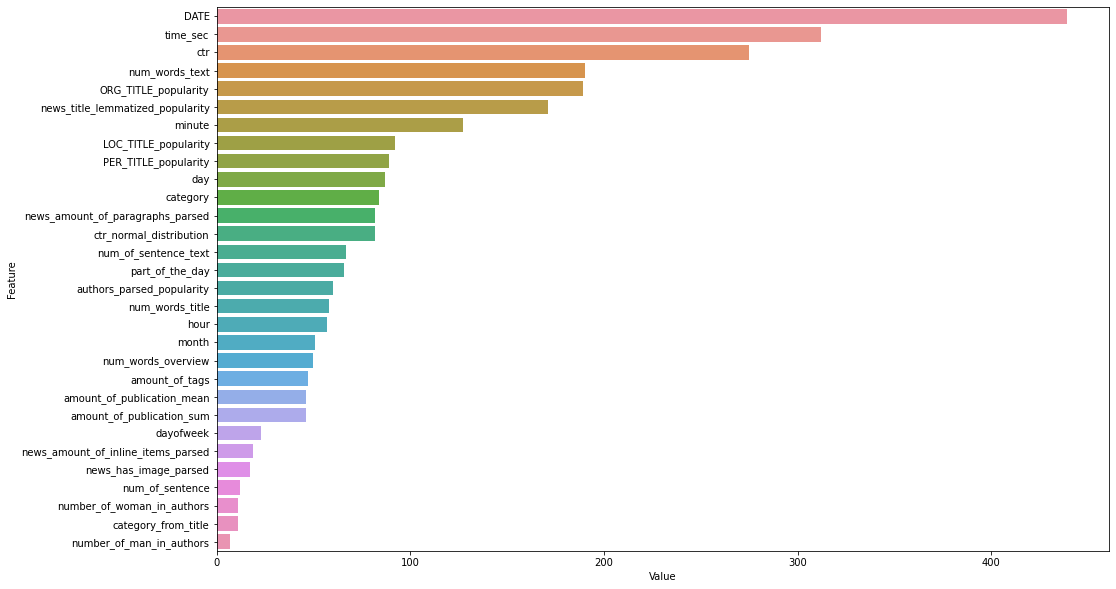

[]
[]
[]
depth:  0.8360334012315204


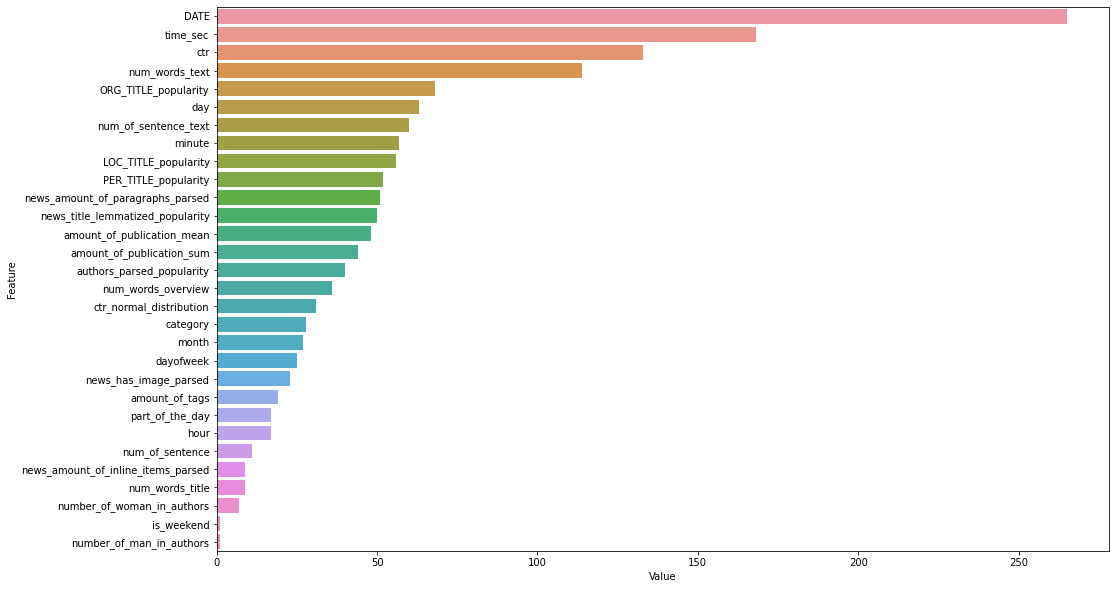

[]
[]
[]
full_reads_percent:  0.5306849419216545


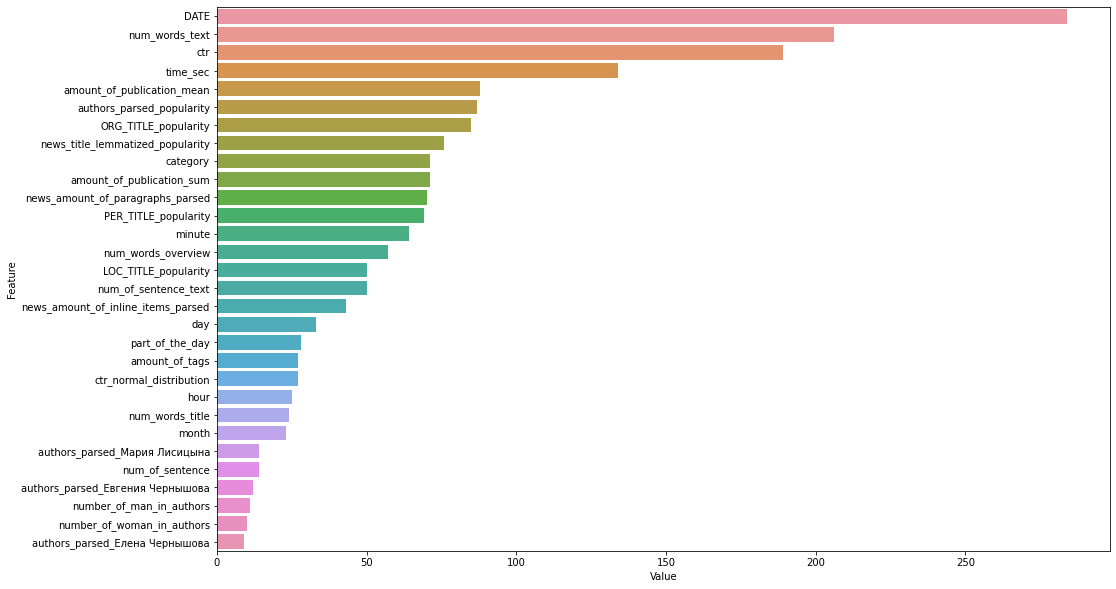

Final score: 0.6906692851039413, median: 0.6894408147934112


In [523]:
result_dict = {
    'views': {'r2': [], 'trees': [], 'prediction': []},
    'full_reads_percent': {'r2': [], 'trees': [], 'prediction': []},
    'depth': {'r2': [], 'trees': [], 'prediction': []}
}
for target_variable in FeaturesConstants.target:
#     if target_variable in ['views', 'depth']:
#         continue
    FeatureGenerator = Compose(
        transforms=[
            DatetimeTransformer(full='use' if target_variable == 'full_reads_percent' else None),
            TitleTransformer(),
            CTRTransformer(eps=0.1 if target_variable == 'views' else 0.5),
            TagsTransformer(),
            AuthorsTransformer(),
            TextTransformer(use_text_transformer=target_variable if target_variable == 'full_reads_percent' else None),
            NatashaTextTransformer(),
            CategoryTransformer(),
            FeatureSelector()
        ]
    )
    train_features = FeatureGenerator(data=train_data, mode='train')
    test_features = FeatureGenerator(data=test_data, mode='test')
    
    for i in ['authors_parsed', 'PER_TITLE', 'ORG_TITLE', 'LOC_TITLE', 'news_title_lemmatized']:
        cec = CountTfIdfVectorizer(
            col=i,
            count_vectorizer=CountVectorizer(
                ngram_range=(1, 4),
            )
        )
        cec.fit(train_data)
        train_features[f'{i}_popularity'] = cec.transform(train_data)
        test_features[f'{i}_popularity'] = cec.transform(test_data)

#     tfidf = TfidfVectorTransformer(
#         col='news_title_lemmatized',
#         tfidf_vectorizer=TfidfVectorizer(
#             ngram_range=(1, 4) if target_variable != 'full_reads_percent' else (1, 4),
#             max_features=256 if target_variable != 'full_reads_percent' else 2048,
#             min_df=3 if target_variable != 'full_reads_percent' else 1
#         )
#     )
#     tfidf.fit(train_data)
#     train_dd = tfidf.transform(train_data)
#     test_dd = tfidf.transform(test_data)
#     train_features = pd.concat([train_features, train_dd], axis=1)
#     test_features = pd.concat([test_features, test_dd], axis=1)
    
        
#     tfidf = TfidfVectorTransformer(
#         col='tags_parsed',
#         tfidf_vectorizer=TfidfVectorizer(
#             ngram_range=(1, 4) if target_variable != 'full_reads_percent' else (1, 4),
#             max_features=256 if target_variable != 'full_reads_percent' else 2048,
#             min_df=5 if target_variable != 'full_reads_percent' else 1
#         )
#     )
#     tfidf.fit(train_data)
#     train_dd = tfidf.transform(train_data)
#     test_dd = tfidf.transform(test_data)
#     train_features = pd.concat([train_features, train_dd], axis=1)
#     test_features = pd.concat([test_features, test_dd], axis=1)
    
    
#     tfidf = TfidfVectorTransformer(
#         col='authors_parsed',
#         tfidf_vectorizer=TfidfVectorizer(
#             ngram_range=(1, 4),
#             max_features=128 if target_variable != 'views' else 64
#         )
#     )
#     tfidf.fit(train_data)
#     train_dd = tfidf.transform(train_data)
#     test_dd = tfidf.transform(test_data)
#     train_features = pd.concat([train_features, train_dd], axis=1)
#     test_features = pd.concat([test_features, test_dd], axis=1)
    
# # #     train_features = pd.concat((train_features, pd.DataFrame(train_embeddings, index=train_features.index)), axis=1)
# # #     test_features = pd.concat((test_features, pd.DataFrame(tets_embeddings, index=test_features.index)), axis=1)
    

    
    if target_variable == 'full_reads_percent':
        ...
        m = MultiLabelTransformer()
        m.fit(train_data)
        train_author = m.transform(train_data)
        test_author = m.transform(test_data)
        train_features = pd.concat([train_features, train_author], axis=1)
        test_features = pd.concat([test_features, test_author], axis=1)


#     import copy
#     train_ebmeddings = copy.deepcopy(embeddings)
#     idx = train_ebmeddings.sum(axis=1) != 0
#     train_ebmeddings[idx] = train_ebmeddings[idx] / np.linalg.norm(train_ebmeddings[idx], ord=2,axis=1).reshape((-1,1))
#     train_features = pd.concat((train_features, pd.DataFrame(train_ebmeddings, index=train_features.index)), axis=1)
    
#     print(train_features.shape, test_features.shape)
    for train_index, val_index in kfold.split(train_features):
        X_train, X_valid = (
            train_features.reset_index(drop=True).iloc[train_index, :], 
            train_features.reset_index(drop=True).iloc[val_index, :]
        )
        y_train, y_valid = (
            y_data[target_variable].reset_index(drop=True).iloc[train_index], 
            y_data[target_variable].reset_index(drop=True).iloc[val_index]
        )
        if target_variable == 'views':
            y_train = np.log(y_train)
            y_valid = np.log(y_valid)
        elif target_variable == 'depth':
            y_train = np.log(np.log(y_train))
            y_valid = np.log(np.log(y_valid))
        else:
            y_train = np.log(y_train)
            y_valid = np.log(y_valid)
            
        if target_variable == 'me':
            pass
        else:
#             dtrain = lgb.Dataset(X_train, label=y_train)
#             dvalid = lgb.Dataset(X_valid, label=y_valid)            
            
            lgbm_regressor = lgb.LGBMRegressor(
                objective='regression',
                random_state=33,
                early_stopping_round=100, 
                n_estimators=500,
                subsample=1,
                colsample_bytree=0.95,
                learning_rate=0.08 if target_variable == 'full_reads_percent' else 0.08,
                max_depth=-1,
                verbose=-1
            )
            lgbm_regressor.fit(X_train, 
                     y_train, 
                     eval_set=[(X_valid, y_valid)], 
                     eval_metric='rmse', verbose=-1)
        y_pred = lgbm_regressor.predict(X_valid)
        r2 = r2_score(y_valid, y_pred)
        result_dict[target_variable]['r2'].append(r2)
        result_dict[target_variable]['trees'].append(lgbm_regressor.booster_.trees_to_dataframe())

        
        pro = lgbm_regressor.predict(test_features)
        if target_variable == 'views':
            pro = np.exp(pro)
        elif target_variable == 'depth':
            pro = np.exp(np.exp(pro))
        else:
            pro = np.exp(pro)
        print(pro[pro < 0])
        result_dict[target_variable]['prediction'].append(pro)
    print(f'{target_variable}: ', np.mean(result_dict[target_variable]['r2']))
    plotImp(lgbm_regressor, train_features, num=30, fig_size=(16, 10))

full_score = (
    np.mean(result_dict['views']['r2']) * 0.4 + 
    np.mean(result_dict['full_reads_percent']['r2']) * 0.3 + 
    np.mean(result_dict['depth']['r2']) * 0.3
)
full_score_2 = (
    np.median(result_dict['views']['r2']) * 0.4 + 
    np.median(result_dict['full_reads_percent']['r2']) * 0.3 + 
    np.median(result_dict['depth']['r2']) * 0.3
)
print(f'Final score: {full_score}, median: {full_score_2}')

# Sub4 - best

In [516]:
sub = pd.DataFrame(
    {
        'document_id': test_data['document_id'].values,
        'views': pd.DataFrame(result_dict['views']['prediction']).T.mean(axis=1),
        'depth': pd.DataFrame(result_dict['depth']['prediction']).T.mean(axis=1),
        'full_reads_percent': pd.DataFrame(result_dict['full_reads_percent']['prediction']).T.mean(axis=1),
    },
)
sub.index = test_data.index

In [517]:
sub_full = pd.concat((sub, exist_prediction)).sort_index()

In [526]:
ss = pd.read_csv('../sub/tfidf_era_sub_2.csv')

In [562]:
train_data['session'].value_counts()[:30]

EXELbCZARXqMsO7phHCm8g    9
xMxkWattR_ewhI94MWFjLg    8
--Gw2xeSSLew3P-cYpuWjw    8
ezJoRfM8Sf-IB1KyxMUVFw    8
KtVJsteHStO5oditt3Uvzw    8
9-07LOJxTTS1wNtCWgacZQ    8
-zEYsVrPSQuC-bROoTMdnw    8
0tPXqm7fSmGB_WovBXRbmQ    8
BGqE5tfuTxeanLvshi8hGw    7
94w9-E9aQKuxKLxY-eR8IA    7
-KnHLDOSTICfnjsk9jrlRg    7
FcJyHDRbSHylVDOv55Aukg    7
3w_TKyM9Tle1M1ShY2tjKg    7
4hoLDPFxQ2WF_Rh1kWS3jA    7
KBd7hn9RSS-AHReGRrpbDw    7
Si7nhKW1Q9SbpmnXyoPTBg    6
5sHoC5DQRYyOR92V_ypG3A    6
vO1lIZGVSA6bcD86zFD_GQ    6
lOQUAlaMTQO0otEhh6r_UA    6
0I6kRWRGSb-LSMjQdTQ_aQ    6
ElkA_lbnQxyj64v8qMevyw    6
EnKFaoAYTiyPoc6WrEv_jQ    6
MK6v4ntiQ-2Duhg-TYNMLA    6
a4w3WaHuRVKaq8_c5nEY6w    6
poaXi1FyR8y5OH9t2cca-g    6
XIDTflVsRiW8S7lilkXgRA    6
61yEul4ZSc6hc_qijFSUQQ    6
rAIba-lERWSXd4O9M1EpAg    6
AL-9lSRYR46n0_5tw7Bd0A    6
50tIkSGVSf2O8XQgk_uaHQ    6
Name: session, dtype: int64

In [556]:
exist_prediction.sort_values(by='document_id')

,document_id,views,depth,full_reads_percent
331,5e2fe9459a79479d102bada65-GHTZ4MQo-zKt9cuxuQ1Q,180456,1.565,14.232
334,5e2fe9459a79479d102bada6RlUORmFKSCeQIU3k31TQyw,180456,1.565,14.232
335,5e2fe9459a79479d102bada6UymrHkuPTsGBJciyz76Ncg,518294,1.589,17.699
333,5e2fe9459a79479d102bada6_gmZn3dIRbS6W6wD_QxVXg,518294,1.589,17.699
332,5e2fe9459a79479d102bada6yfcODULGSw2Dzodfelkb3Q,518294,1.589,17.699
797,5f8017369a794784407ebca7NsqxLkaMRtCRW85BYyHutg,53426,1.231,44.076
798,5f8017369a794784407ebca7toxSxkd7QIG9mCXM2_FaLA,129984,1.292,40.749
1956,5f92bea39a7947522989725anJKpH0TQRQuVH_QA56sSMg,28497,1.164,29.445
1186,6082cca79a79471b74bf1edaQysaZPGNScaX2y_RicuRQw,22374,1.186,44.61
161,609d11a69a79477cef513697IOrn2VSSTFq1lnfWNWSjmg,74837,1.162,21.686


In [550]:
ss.to_csv(SUB_DIR / 'ERY3.csv', index=False)

In [548]:
sub_full_2 = pd.DataFrame(ss['document_id'])

In [520]:
views = []
full_reads_percent = []
depth = []
for j, i in sub_full_2.iterrows():
    dummy = sub_full[sub_full['document_id'] == i['document_id']]
    views.append(dummy['views'].values[0])
    full_reads_percent.append(dummy['full_reads_percent'].values[0])
    depth.append(dummy['depth'].values[0])

In [521]:
sub_full_2['views'] = views
sub_full_2['full_reads_percent'] = full_reads_percent
sub_full_2['depth'] = depth

In [522]:
sub_full_2.to_csv(SUB_DIR / 'ERY2.csv', index=False)

In [ ]:
ss = pd.read_csv('../sub/sample_solution.csv')